# Group Assignment QF627

<font size = 5>**Group Members:**</font>
* Anna Germaine Lim
* Chen Pengyu
* Gregory Tan
* Zenith Tay

# Contribution Statement

Name        |Work Contributed                                                                           |
---         |   ---                                                                                     |
Zenith      |Supervised Learning Models and Codes, Report Writing, Team Reflections                           |
Gregory     |   Momentum Trading Strategies and Codes, Report Writing and Collation, Team Reflections             |
Anna        |Mean-Reversion Strategies and Codes, Report Writing, Team Reflections                                |
Pengyu      |Report Writing, Team Reflections, Attempts on unsupervised learning                        |

# Prep Work

## Packages Used in This Workbook

In [2]:
## Data Download

import yfinance as yf
import numpy as np
import pandas as pd
from datetime import datetime
import pandas_datareader as pdr

## For Visualisation

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

## Functions

### Download of Data

In [4]:
start_date = "2006-11-01"
end_date = "2025-11-13"

In [5]:
def download_data (ticker: list[str] | str,
                   start_date = start_date, 
                   end_date = end_date,
                   close_only = False) -> pd.DataFrame:
    if close_only == False:
        data =\
        (
            yf.download(tickers = ticker,
                        start = start_date,
                        end = end_date)
        )
    else:
        data =\
        (
            yf.download(tickers = ticker,
                        start = start_date,
                        end = end_date)
                        ["Close"]
        )    

    return data

In [6]:
# preallocate empty array and assign slice by chrisaycock

def np_shift(arr, num, fill_value=np.nan):
    result = np.empty_like(arr)
    if num > 0:
        result[:num] = fill_value
        result[num:] = arr[:-num]
    elif num < 0:
        result[num:] = fill_value
        result[:num] = arr[-num:]
    else:
        result[:] = arr
    return result

### Performance Metrics

In [7]:
## Annualised Sharpe

def annual_sharpe(returns):
    days = (returns.index[-1] - returns.index[0]).days
    
    return\
    (
        (
            (1+returns).prod()
            **(365/days) 
            - 1
        )
        /
        returns.std()
        /
        np.sqrt(252)
    )

In [8]:
## CAGR

def cagr(returns: pd.Series) -> float:
    days = (returns.index[-1] - returns.index[0]).days
    return ( (1 + returns).prod() )**(365/days) - 1   

In [9]:
### Max Drawdown

def max_drawdown(cumulative_returns):
    max_performance = cumulative_returns.cummax()
    dd = ((max_performance - cumulative_returns) / max_performance).max()
    return dd


### Longest Drawdown

def calculate_longest_drawdown(cumulative_returns):
    drawdown = cumulative_returns.cummax() - cumulative_returns
    period =\
    (
        np
        .diff(np
              .append(drawdown[drawdown == 0].index, 
                      drawdown.index[-1: ]
                    )
            )
    )
    return period.max() / np.timedelta64(1, "D")

In [10]:
def evaluate_returns(returns_series: pd.Series, to_print: bool = False):
    
    cum_returns_series = (1 + returns_series).cumprod()

    tot_returns = (1 + returns_series).prod() - 1
    CAGR = cagr(returns_series)
    Annualised_Sharpe = annual_sharpe(returns_series)
    Max_DD = max_drawdown(cum_returns_series)
    Longest_DD = calculate_longest_drawdown(cum_returns_series)

    if to_print == True:
      print('-- Summary of Returns -- \n',
            f'Total Returns: {tot_returns: .2%} \n',
            f'CAGR: {CAGR: .2%} \n',
            f'Annualised_Sharpe: {Annualised_Sharpe: .2%} \n',
            f'Max Drawdown: {Max_DD: .2%} \n',
            f'Longest Drawdown (Days): {Longest_DD}'            
            )

    return pd.Series([tot_returns, CAGR, Annualised_Sharpe, Max_DD, Longest_DD])

In [11]:
def generate_returns(price_data: pd.DataFrame,
                     price_col: 'str' = 'Close') -> pd.Series:
    
    returns_series = price_data[price_col].pct_change()
    cum_returns_series = (1 + returns_series).cumprod()

    tot_returns = float(cum_returns_series.iloc[-1].iloc[0])

    print('=== Summary of Returns === \n',
          f'Total Returns = {tot_returns: .2%}'
          )

    return tot_returns, returns_series, cum_returns_series

## Download Dataset

In [12]:
spy_data =\
(
    download_data("SPY", start_date, end_date)
)
spy_data

C:\Users\TanFamily4\AppData\Local\Temp\ipykernel_28728\1882972918.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  yf.download(tickers = ticker,
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
2006-11-01,95.973602,96.990418,95.875427,96.927308,83005600
2006-11-02,95.917526,96.078812,95.623001,95.728185,60693100
2006-11-03,95.749214,96.345284,95.104062,96.261137,71346400
2006-11-06,96.829163,96.969411,96.036742,96.043761,63303300
2006-11-07,97.200821,97.460281,96.773056,96.913304,63318900
...,...,...,...,...,...
2025-11-06,670.309998,677.380005,668.719971,676.469971,85035300
2025-11-07,670.969971,671.080017,661.210022,667.909973,100592400


In [13]:
spy_data = \
    (
        spy_data
        .droplevel(
            level = 1,
            axis =1
        )
    )

# Part 1 and 2: Analysis, Visualisation and Strategy

Data Wrangling and Preparation

In [14]:
train_pct = 0.75
train_test_split_index = int(train_pct*len(spy_data))

spy_train_data =\
    (
        spy_data
        .copy()
        .iloc[ : train_test_split_index]
    )

spy_test_data =\
    (
        spy_data
        .copy()
        .iloc[train_test_split_index : ]
    )

In [15]:
len(spy_train_data) + len(spy_test_data)

4788

In [16]:
display(spy_train_data, spy_train_data)

Price,Close,High,Low,Open,Volume
Date,,,,,
2006-11-01,95.973602,96.990418,95.875427,96.927308,83005600
2006-11-02,95.917526,96.078812,95.623001,95.728185,60693100
2006-11-03,95.749214,96.345284,95.104062,96.261137,71346400
2006-11-06,96.829163,96.969411,96.036742,96.043761,63303300
2006-11-07,97.200821,97.460281,96.773056,96.913304,63318900
...,...,...,...,...,...
2021-02-02,357.220367,358.783892,352.323878,355.441527,64450700
2021-02-03,357.501221,359.233261,356.218584,358.053596,52427100
2021-02-04,361.564453,361.611253,357.613542,358.540405,47142600


Price,Close,High,Low,Open,Volume
Date,,,,,
2006-11-01,95.973602,96.990418,95.875427,96.927308,83005600
2006-11-02,95.917526,96.078812,95.623001,95.728185,60693100
2006-11-03,95.749214,96.345284,95.104062,96.261137,71346400
2006-11-06,96.829163,96.969411,96.036742,96.043761,63303300
2006-11-07,97.200821,97.460281,96.773056,96.913304,63318900
...,...,...,...,...,...
2021-02-02,357.220367,358.783892,352.323878,355.441527,64450700
2021-02-03,357.501221,359.233261,356.218584,358.053596,52427100
2021-02-04,361.564453,361.611253,357.613542,358.540405,47142600


## (1A) Momentum Trading Strategy

### Functions to Generate Positions and Signals

In [17]:
## Moving Average

def generate_moving_avg(price_data: pd.Series,
                        window: int
                                              ) -> pd.Series:
    
    ma_series =\
    (
        pd.Series
        (   
            price_data
            .rolling(window = window)
            .mean(),

            name = 'MA' + str(window)
        )
    )

    return ma_series

In [18]:
## Exponential Moving Average

def generate_EMA(price_data: pd.Series, 
                    window: int
                            ) -> pd.Series:
    EMA = pd.Series(price_data
                    .ewm(span = window,
                         min_periods = window)
                    .mean(),
                    name = "EMA_" + str(window)
                    )
    return EMA

In [19]:
def generate_moving_avg_cross_signal(long_ma: pd.Series,
                                    short_ma: pd.Series) -> pd.Series:
    
    ## Sanity Check
    if len(long_ma) != len(short_ma):
        print('MA series lengths not equal, please check')
        return

    ## Return Signals
    else:

        moving_avg_cross_positions = np.where(short_ma > long_ma, 1.0, 0.0)
        moving_avg_cross_positions = np.where(short_ma < long_ma, -1.0 , moving_avg_cross_positions)

        moving_avg_cross_signals = np.where(moving_avg_cross_positions - np_shift(moving_avg_cross_positions,1) > 0, 1, 0)
        moving_avg_cross_signals = np.where(moving_avg_cross_positions - np_shift(moving_avg_cross_positions, 1) < 0, -1, moving_avg_cross_signals)

        buy_or_sell = pd.DataFrame({'MA_Cross_Signal':moving_avg_cross_signals, 'MA_Cross_Position': moving_avg_cross_positions},
                                   index = long_ma.index
                                   )

        return buy_or_sell

In [20]:
## Rate of Change

def generate_rate_of_change(price_data: pd.Series,
                            n: int
                            ) -> pd.Series:
    
    ROC = pd.Series(
                        (price_data - price_data.diff(n)) / price_data.diff(n),
                        name = 'ROC'+str(n),
                        # index = price_data.index
                    )
    
    return ROC

In [21]:
def generate_rate_of_change_signal(roc_data: pd.Series) -> pd.Series:

    roc_position = pd.Series(np.where(roc_data > 0, 1.0, 0.0), index=roc_data.index, name = 'ROC_Position')
    roc_signal = roc_position.diff()
    roc_signal.name = 'ROC_Signal'
    
    # roc_signal = roc_position - np_shift(roc_position, 1)


    # buy_or_sell = pd.DataFrame({'ROC_Position': roc_position, 'ROC_Signal': roc_signal},
    #                         #    index = roc_data.index
    #                            )

    return pd.concat([roc_position, roc_signal], axis=1)

In [22]:
## RSI

def generate_RSI(series, period):
    
    delta = series.diff().dropna()
    
    u = delta * 0
    d = u.copy()
    
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    
    u[u.index[period - 1]] = np.mean( u[:period] ) # 
    
    u = u.drop(u.index[:(period - 1)
                      ]
              )
    
    d[d.index[period - 1]] = np.mean( d[:period] )
    
    d = d.drop(d.index[:(period - 1)
                      ]
              )
    
    rs = u.ewm(com = period - 1, adjust = False).mean() / \
         d.ewm(com = period - 1, adjust = False).mean()
    
    return pd.Series( (100 - 100 / (1 + rs)),
                     name = f'RSI{period}'
                )

In [23]:
def generate_rsi_signal(rsi_data: pd.Series) -> pd.Series:

    rsi_position = pd.Series(np.where(rsi_data > 50, 1.0, -1.0), 
                             index= rsi_data.index, 
                             name = 'rsi_position')
    
    rsi_signal = rsi_position.diff()
    rsi_signal.name = 'rsi_signal'
    
    # rsi_signal = rsi_position - np_shift(rsi_position, 1)


    # buy_or_sell = pd.DataFrame({'rsi_position': rsi_position, 'rsi_signal': rsi_signal},
    #                         #    index = rsi_data.index
    #                            )

    return pd.concat([rsi_position, rsi_signal], axis=1)

In [24]:
def generate_force_index(data_price: pd.Series, data_vol: pd.Series, period: int) -> pd.Series:

    indicator = data_price.diff() * data_vol
    lag_indicator = indicator.ewm(span = period, adjust = False).mean()

    return lag_indicator

In [25]:
def generate_force_index_signal(data: pd.Series) -> pd.Series:

    position = pd.Series(np.where(data >= 0, 1.0, -1.0),
                        index = data.index,
                        name = 'FI_position'
                        )
    signal = position.diff()/2
    signal.name = 'FI_signal'

    return pd.concat([position, signal], axis = 1)

In [32]:
def generate_ROC_RSI(close_data_series, num_ROC, num_RSI):

    buy_sell =\
    (
        pd
        .concat([generate_rate_of_change_signal(generate_rate_of_change(close_data_series, num_ROC)), generate_rsi_signal(generate_RSI(close_data_series, num_RSI))],
                axis = 1
                )
    )

    buy_sell['position'] = 0

    (
        buy_sell
        .loc[( (buy_sell['ROC_Position'] > 0) & (buy_sell['rsi_position'] > 0) ),
            'position'
            ]
    ) = 1

    buy_sell['Returns'] = spy_data_returns['Returns']

    buy_sell['signal'] = buy_sell['position'].diff()
    buy_sell['Price'] = spy_data_close

    buy_sell['Strat_Returns'] = buy_sell['Returns']*buy_sell['position']

    (
        (1 + buy_sell['Strat_Returns'])
        .cumprod()
    ).plot()


    return (
                (1 + buy_sell['Returns']*buy_sell['position'])
                .prod()
                -1
            ), buy_sell

### Functions to Generate Metrics

In [27]:
## Annualised Sharpe

def annual_sharpe(returns):
    days = (returns.index[-1] - returns.index[0]).days
    
    return\
    (
        (
            (1+returns).prod()
            **(365/days) 
            - 1
        )
        /
        returns.std()
        /
        np.sqrt(252)
    )

## CAGR

def cagr(returns: pd.Series) -> float:
    days = (returns.index[-1] - returns.index[0]).days
    return ( (1 + returns).prod() )**(365/days) - 1   

### Max Drawdown

def max_drawdown(cumulative_returns):
    max_performance = cumulative_returns.cummax()
    dd = ((max_performance - cumulative_returns) / max_performance).max()
    return dd

### Longest Drawdown

def calculate_longest_drawdown(cumulative_returns):
    drawdown = cumulative_returns.cummax() - cumulative_returns
    period =\
    (
        np
        .diff(np
              .append(drawdown[drawdown == 0].index, 
                      drawdown.index[-1: ]
                    )
            )
    )
    return period.max() / np.timedelta64(1, "D")

### Evaluate Returns in Totality

def evaluate_returns(returns_series: pd.Series, to_print: bool = False):
    
    cum_returns_series = (1 + returns_series).cumprod()

    tot_returns = (1 + returns_series).prod() - 1
    CAGR = cagr(returns_series)
    Annualised_Sharpe = annual_sharpe(returns_series)
    Max_DD = max_drawdown(cum_returns_series)
    Longest_DD = calculate_longest_drawdown(cum_returns_series)

    if to_print == True:
      print('-- Summary of Returns -- \n',
            f'Total Returns: {tot_returns: .2%} \n',
            f'CAGR: {CAGR: .2%} \n',
            f'Annualised_Sharpe: {Annualised_Sharpe: .2%} \n',
            f'Max Drawdown: {Max_DD: .2%} \n',
            f'Longest Drawdown (Days): {Longest_DD}'            
            )

    return pd.Series([tot_returns, CAGR, Annualised_Sharpe, Max_DD, Longest_DD])

### Download Dataset

In [28]:
train_proportion = 0.75

spy_data =\
(
    download_data('SPY',
                  start_date = '2006-11-01',
                  end_date = '2025-11-12')
    .droplevel(level = 1,
               axis = 1)
    [['Close', 'Volume']]
).resample('W-FRI').agg({'Close': 'last', 'Volume': 'sum'})

spy_train_data = spy_data[:int(train_proportion*len(spy_data))]

spy_data_close = spy_train_data['Close'].to_frame()
spy_data_returns = spy_train_data['Close'].pct_change().to_frame().rename(columns= {'Close': 'Returns'})

C:\Users\TanFamily4\AppData\Local\Temp\ipykernel_28728\1882972918.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  yf.download(tickers = ticker,
[*********************100%***********************]  1 of 1 completed


In [29]:
evaluate_returns(spy_data_returns['Returns'], to_print=True);

-- Summary of Returns -- 
 Total Returns:  279.10% 
 CAGR:  9.79% 
 Annualised_Sharpe:  23.57% 
 Max Drawdown:  54.61% 
 Longest Drawdown (Days): 1771.0


(np.float64(6.114935773216809),
             ROC_Position  ROC_Signal  rsi_position  rsi_signal  position  \
 Date                                                                       
 2006-11-03           0.0         NaN           NaN         NaN         0   
 2006-11-10           0.0         0.0           NaN         NaN         0   
 2006-11-17           0.0         0.0           NaN         NaN         0   
 2006-11-24           0.0         0.0           NaN         NaN         0   
 2006-12-01           0.0         0.0           NaN         NaN         0   
 ...                  ...         ...           ...         ...       ...   
 2021-01-08           1.0         0.0           1.0         0.0         1   
 2021-01-15           1.0         0.0           1.0         0.0         1   
 2021-01-22           1.0         0.0           1.0         0.0         1   
 2021-01-29           1.0         0.0           1.0         0.0         1   
 2021-02-05           1.0         0.0       

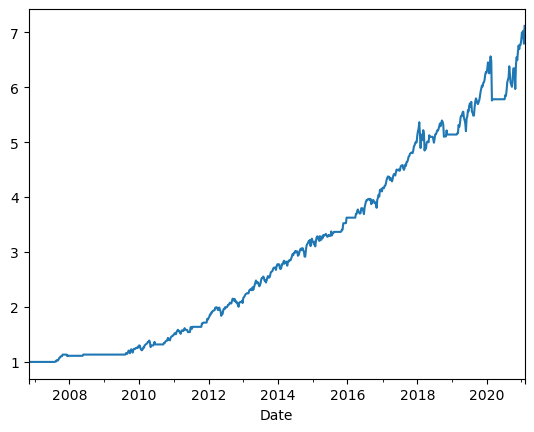

In [33]:
generate_ROC_RSI(spy_data_close['Close'], 20, 40)

### FI Train (No Luck)
FI Signals attempted to include volume to indicate strength of the turn. However for indication of trends, not very useful

In [102]:
time_periods = np.arange(10, 201, 10).tolist()

In [103]:
def generate_fi_Metrics(time_periods):

    Metrics = pd.DataFrame()

    for i in time_periods:

        data = spy_data_returns.copy()
        
        data[f'fi{i}'] = generate_force_index(spy_data['Close'], spy_data['Volume'], i)
        
        data = pd.concat([data, generate_force_index_signal(data[f'fi{i}'])], axis = 1)
        
        data['Strat_returns'] = data['Returns'] * data['FI_position'].shift(1)
        
        # print(f'===Data for ROC{i}===')
        strat_series = evaluate_returns(data['Strat_returns'])
        strat_series.name = f'FI{i}'
        
        Metrics = pd.concat([Metrics, strat_series], axis = 1)

    Metrics.index = ['Total Returns', 'CAGR', 'Annualised Sharpe', 'Max Drawdown', 'Longest Drawdown (Days)']
    return Metrics.T

In [104]:
generate_fi_Metrics(list(range(10,251,10))).sort_values(by = 'Annualised Sharpe', ascending=False)

,Total Returns,CAGR,Annualised Sharpe,Max Drawdown,Longest Drawdown (Days)
FI10,-0.374803,-0.032382,-0.077718,0.484256,4354.0
FI40,-0.551479,-0.054644,-0.131192,0.725768,4354.0
FI20,-0.552317,-0.054768,-0.131490,0.722404,4354.0
FI50,-0.572263,-0.057782,-0.138736,0.751454,4354.0
FI30,-0.586337,-0.059989,-0.144043,0.715842,4354.0
FI60,-0.601475,-0.062442,-0.149942,0.768428,4354.0
FI70,-0.601661,-0.062473,-0.150015,0.749208,4354.0
FI80,-0.669855,-0.074730,-0.179515,0.796985,4354.0
FI110,-0.672303,-0.075212,-0.180677,0.802884,4354.0
FI100,-0.673992,-0.075547,-0.181484,0.803712,4354.0


### ROC (No Luck)
ROC Signals Significantly Underperformed the Market

In [105]:
def generate_ROC_Metrics(time_periods):

    ROC_Metrics = pd.DataFrame()

    for i in time_periods:
        roc_data = spy_data_returns.copy()
        
        roc_data[f'ROC{i}'] = generate_rate_of_change(spy_data_close['Close'], i)
        roc_data = pd.concat([roc_data, generate_rate_of_change_signal(roc_data[f'ROC{i}'])], axis = 1)
        roc_data['Strat_returns'] = roc_data['Returns'] * roc_data['ROC_Position'].shift(1)
        
        # print(f'===Data for ROC{i}===')
        roc_series = evaluate_returns(roc_data['Strat_returns'])
        roc_series.name = f'ROC{i}'
        
        ROC_Metrics = pd.concat([ROC_Metrics, roc_series], axis = 1)

    ROC_Metrics.index = ['Total Returns', 'CAGR', 'Annualised Sharpe', 'Max Drawdown', 'Longest Drawdown (Days)']
    return ROC_Metrics.T

In [106]:
generate_ROC_Metrics(time_periods).sort_values(by = 'Annualised Sharpe', ascending=False)

,Total Returns,CAGR,Annualised Sharpe,Max Drawdown,Longest Drawdown (Days)
ROC100,2.546123,0.092771,0.321478,0.318290,357.0
ROC70,2.541797,0.092678,0.321278,0.202251,714.0
ROC170,2.467796,0.091062,0.320582,0.318290,315.0
ROC150,2.704476,0.096122,0.319853,0.318290,315.0
ROC190,2.363654,0.088733,0.319185,0.318290,315.0
ROC200,2.302027,0.087323,0.315491,0.318290,427.0
ROC90,2.555622,0.092976,0.315144,0.318290,357.0
ROC80,2.403232,0.089626,0.310517,0.212966,938.0
ROC180,2.290073,0.087046,0.309823,0.318290,322.0
ROC130,2.400761,0.089570,0.303794,0.332359,315.0


### RSI (No Luck Either)

In [107]:
def generate_RSI_Metrics(time_periods):

    Metrics = pd.DataFrame()

    for i in time_periods:
        data = spy_data_returns.copy()
        
        data[f'RSI{i}'] = generate_RSI(spy_data_close['Close'], i)
        
        data = pd.concat([data, generate_rsi_signal(data[f'RSI{i}'])], axis = 1)
        
        data['Strat_returns'] = data['Returns'] * data['rsi_position'].shift(1)
        
        # print(f'===Data for ROC{i}===')
        strat_series = evaluate_returns(data['Strat_returns'])
        strat_series.name = f'RSI{i}'
        
        Metrics = pd.concat([Metrics, strat_series], axis = 1)

    Metrics.index = ['Total Returns', 'CAGR', 'Annualised Sharpe', 'Max Drawdown', 'Longest Drawdown (Days)']
    return Metrics.T

In [108]:
generate_RSI_Metrics(range(10, 252, 10)).sort_values(by = 'Annualised Sharpe', ascending = False)

,Total Returns,CAGR,Annualised Sharpe,Max Drawdown,Longest Drawdown (Days)
RSI180,1.674252,0.071372,0.171632,0.559958,3073.0
RSI250,1.481154,0.065759,0.158098,0.578603,3199.0
RSI190,1.471128,0.065457,0.157369,0.580306,3206.0
RSI200,1.397001,0.063185,0.151893,0.592896,3227.0
RSI210,1.347383,0.061628,0.148140,0.601323,3241.0
RSI220,1.246127,0.058352,0.140248,0.618520,3465.0
RSI240,1.243048,0.058250,0.140003,0.619043,3465.0
RSI80,1.079755,0.052659,0.126539,0.574706,3010.0
RSI230,1.063855,0.052093,0.125176,0.649477,3899.0
RSI170,0.934571,0.047334,0.113722,0.604903,3227.0


### ROC + RSI?

### MA and EMA
Moving Average Crossovers seem more promising from the 10 years of data data

In [109]:
MA_list =\
(
    list(range(10, 201, 10))
) 

In [110]:
def generate_ema_cross_metrics(short_ma: list[int], long_ma: list[int]) -> pd.Series:
    
    ma_cross_data = spy_data_close.copy()
    ma_cross_summary_table = pd.DataFrame()

    for j in long_ma:

        for i in short_ma:

            if i < j:
            
                short_ma_cross_data = generate_EMA(ma_cross_data['Close'], i)             
                long_ma_cross_data = generate_EMA(ma_cross_data['Close'], j)

                ma_cross_returns =\
                (
                    pd
                    .concat(
                            (spy_data_returns, generate_moving_avg_cross_signal(long_ma_cross_data, short_ma_cross_data)),
                            axis = 1
                            )
                )

                ma_cross_returns['Strat_Returns'] = ma_cross_returns['Returns']*ma_cross_returns['MA_Cross_Position'].shift(1)

                ma_cross_summary_stat_series = evaluate_returns(ma_cross_returns['Strat_Returns'])
                ma_cross_summary_stat_series.name = f'EMA{i} + EMA{j}'


                ma_cross_summary_table = pd.concat([ma_cross_summary_table, ma_cross_summary_stat_series], axis = 1)

    ma_cross_summary_table.index = ['Total Returns', 'CAGR', 'Annualised Sharpe', 'Max Drawdown', 'Longest Drawdown (Days)']
    return ma_cross_summary_table.T

In [111]:
generate_ema_cross_metrics(MA_list, MA_list).sort_values(by = 'Annualised Sharpe', ascending=False).head(10)

,Total Returns,CAGR,Annualised Sharpe,Max Drawdown,Longest Drawdown (Days)
EMA20 + EMA190,3.279348,0.107260,0.346182,0.31829,315.0
EMA20 + EMA200,3.105238,0.104042,0.341948,0.31829,315.0
EMA40 + EMA180,3.178071,0.105403,0.334738,0.31829,315.0
EMA10 + EMA200,2.988187,0.101806,0.334526,0.31829,315.0
EMA30 + EMA200,2.988187,0.101806,0.334526,0.31829,315.0
EMA40 + EMA190,2.974202,0.101535,0.327523,0.31829,315.0
EMA30 + EMA180,3.031249,0.102635,0.325865,0.31829,315.0
EMA20 + EMA180,3.018455,0.102390,0.325078,0.31829,315.0
EMA50 + EMA180,2.974570,0.101542,0.322360,0.31829,315.0
EMA10 + EMA170,2.987195,0.101787,0.321722,0.31829,371.0


In [112]:
def generate_ma_cross_metrics(short_ma: list[int], long_ma: list[int]) -> pd.Series:
    
    ma_cross_data = spy_data_close.copy()

    ma_cross_summary_table = pd.DataFrame()

    for j in long_ma:

        for i in short_ma:

            if i < j:
            
                short_ma_cross_data = generate_moving_avg(ma_cross_data['Close'], i)
                long_ma_cross_data = generate_moving_avg(ma_cross_data['Close'], j)

                ma_cross_returns =\
                (
                    pd
                    .concat(
                            (spy_data_returns, generate_moving_avg_cross_signal(long_ma_cross_data, short_ma_cross_data)),
                            axis = 1
                            )
                )

                ma_cross_returns['Strat_Returns'] = ma_cross_returns['Returns']*ma_cross_returns['MA_Cross_Position'].shift(1)

                ma_cross_summary_stat_series = evaluate_returns(ma_cross_returns['Strat_Returns'])
                ma_cross_summary_stat_series.name = f'MA{i} + MA{j}'


                ma_cross_summary_table = pd.concat([ma_cross_summary_table, ma_cross_summary_stat_series], axis = 1)

    ma_cross_summary_table.index = ['Total Returns', 'CAGR', 'Annualised Sharpe', 'Max Drawdown', 'Longest Drawdown (Days)']
    return ma_cross_summary_table.T, ma_cross_returns

In [113]:
ma_cross_summary = generate_ma_cross_metrics(MA_list, MA_list)[0]
ma_cross_summary.sort_values(by = 'Total Returns', ascending = False).head(10)

,Total Returns,CAGR,Annualised Sharpe,Max Drawdown,Longest Drawdown (Days)
MA40 + MA90,3.466237,0.110583,0.278230,0.437183,1589.0
MA40 + MA160,3.349127,0.108516,0.341280,0.318290,315.0
MA40 + MA150,3.094130,0.103832,0.322501,0.318290,385.0
MA30 + MA150,3.063535,0.103252,0.320682,0.318290,399.0
MA50 + MA70,3.056257,0.103113,0.256137,0.464209,1715.0
MA50 + MA150,3.055235,0.103094,0.320187,0.318290,399.0
MA30 + MA100,2.999716,0.102029,0.257376,0.443429,1687.0
MA30 + MA160,2.986585,0.101775,0.319881,0.318290,315.0
MA140 + MA180,2.979288,0.101633,0.322653,0.318290,581.0
MA50 + MA160,2.925160,0.100576,0.316080,0.318290,315.0


### Test Dataset
Moving Average Was tested against benchmark, with allowance of test data to spillover into training data to allow the Moving Average to Generate Signals at the start of the test

In [36]:
row = 0

spy_test_data = spy_data[int(train_proportion*len(spy_data)-row):]

spy_data_close = spy_test_data['Close'].to_frame()
spy_data_returns = spy_test_data['Close'].pct_change().to_frame().rename(columns= {'Close': 'Returns'})

# display(spy_test_data[row:])

evaluate_returns(spy_data_returns.loc[spy_data_returns.index[row:],'Returns'], to_print=True);

-- Summary of Returns -- 
 Total Returns:  85.80% 
 CAGR:  13.91% 
 Annualised_Sharpe:  38.96% 
 Max Drawdown:  23.93% 
 Longest Drawdown (Days): 714.0


In [153]:
evaluate_returns(generate_ma_cross_metrics([40], [160])[1]['Strat_Returns'], to_print=True)

-- Summary of Returns -- 
 Total Returns:  36.07% 
 CAGR:  6.69% 
 Annualised_Sharpe:  32.27% 
 Max Drawdown:  16.88% 
 Longest Drawdown (Days): 133.0


0      0.360676
1      0.066897
2      0.322690
3      0.168772
4    133.000000
dtype: float64

(np.float64(1.11100952003908),             ROC_Position  ROC_Signal  rsi_position  rsi_signal  position  \
Date                                                                       
2021-02-12           0.0         NaN           NaN         NaN         0   
2021-02-19           0.0         0.0           NaN         NaN         0   
2021-02-26           0.0         0.0           NaN         NaN         0   
2021-03-05           0.0         0.0           NaN         NaN         0   
2021-03-12           0.0         0.0           NaN         NaN         0   
...                  ...         ...           ...         ...       ...   
2025-10-17           1.0         0.0           1.0         0.0         1   
2025-10-24           1.0         0.0           1.0         0.0         1   
2025-10-31           1.0         0.0           1.0         0.0         1   
2025-11-07           1.0         0.0           1.0         0.0         1   
2025-11-14           1.0         0.0           1.0       

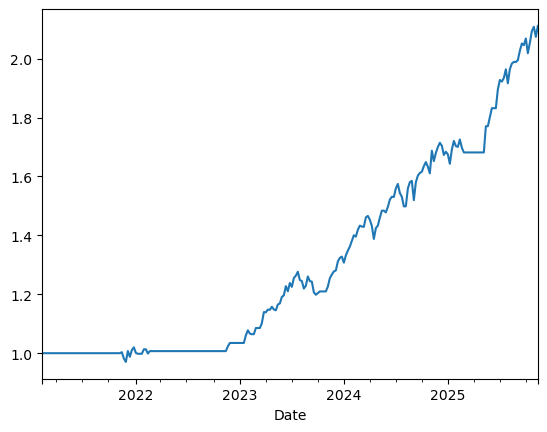

In [37]:
print(generate_ROC_RSI(spy_data_close['Close'], 20, 40))

In [154]:
print('== Strategy Return of MA ==')
evaluate_returns(generate_ma_cross_metrics([40], [160])[1]['Strat_Returns'], to_print=True);

print('\n')

print('== Benchmark Returns ==')
evaluate_returns(spy_data_returns.loc[spy_data_returns.index[160:],'Returns'], to_print=True);

== Strategy Return of MA ==
-- Summary of Returns -- 
 Total Returns:  36.07% 
 CAGR:  6.69% 
 Annualised_Sharpe:  32.27% 
 Max Drawdown:  16.88% 
 Longest Drawdown (Days): 133.0


== Benchmark Returns ==
-- Summary of Returns -- 
 Total Returns:  36.07% 
 CAGR:  20.02% 
 Annualised_Sharpe:  58.18% 
 Max Drawdown:  16.88% 
 Longest Drawdown (Days): 133.0


In [303]:
(spy_data_close.pct_change()+1).prod()-1

Close    0.857982
dtype: float64

In [297]:
test_df = spy_data_close.copy()
test_df

,Close
Date,
2021-02-12,367.603119
2021-02-19,365.159607
2021-02-26,356.106171
2021-03-05,359.167755
2021-03-12,368.932587
...,...
2025-10-17,664.390015
2025-10-24,677.250000
2025-10-31,682.059998


In [1]:
fig, ax = plt.subplots(figsize = [16,8])

ax.plot(buy_sell.index, buy_sell['Price'])
ax.plot(buy_sell.loc[buy_sell['signal'] == 1].index, buy_sell.loc[buy_sell['signal'] == 1, 'Price'], '^g', markersize = 7)
ax.plot(buy_sell.loc[buy_sell['signal'] == -1].index, buy_sell.loc[buy_sell['signal'] == -1, 'Price'], 'vr', markersize = 7)

plt.show()

NameError: name 'plt' is not defined

## Mixed Strategies